In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [101]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time
from torch.nn import functional as F
from torchvision import models
import torch.nn as nn
import torch
import random
import PIL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [100]:
import numpy as np
import pandas as pd

images = []
label = []
import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/batik'):
  for filename in filenames:
    images.append(os.path.join(dirname, filename).split('/')[-1])
    label.append(os.path.join(dirname, filename).split('/')[-2])

In [102]:
labels = np.unique(label)
ints = np.arange(0, len(label))
dicts = dict(zip(labels, ints))
dicts

{'batik-bali': 0, 'batik-betawi': 1, 'batik-celup': 2, 'batik-cendrawasih': 3}

In [ ]:
PATH = "/content/drive/Shared/batik/"

df_full = pd.DataFrame({'image_id':images, 'label':label})

index = []
for i in range(len(df_full)):
    try:
        Image.open(PATH + str(df_full['label'].values[i]) + '/' + str(df_full['image_id'].values[i]))
    
    except PIL.UnidentifiedImageError:
        index.append(i)

df = df_full.drop(index)
df.head()

,image_id,label
0,11.jpg,batik-bali
1,10.jpg,batik-bali
2,1.jpg,batik-bali
3,27.jpg,batik-bali
4,14.jpg,batik-bali


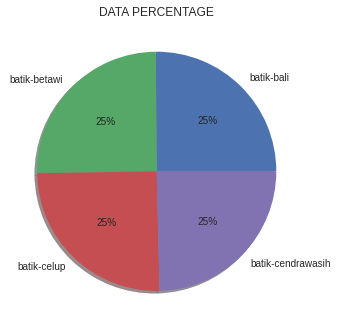

In [ ]:
target, count = np.unique(df['label'], return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = target,  autopct='%1.f%%', shadow=True)
plt.title('DATA PERCENTAGE')
plt.show()

In [105]:
class Batik(Dataset):
    def __init__(self, x, y, path, map_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

    def __len__(self):
        return len(self.X)
    
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image_id'].values, df['label'].values, 
    test_size=0.15, stratify=df['label'].values, 
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, 
    stratify=y_trainval, test_size=0.15,
    random_state=77)


len(X_train), len(X_val), len(X_test)

(143, 26, 30)

In [106]:
mean= [0.485, 0.456, 0.406] 
std= [0.229, 0.224, 0.225]
batch_size = 24

train_transform = T.Compose([T.Resize((128, 128)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])
#berisi data campuran yang sudah digabungkan dengan data augmentation
train_set = Batik(X_train, y_train, PATH, transform=train_transform)
val_set = Batik(X_val, y_val, PATH, transform=val_transform)
#fungsi dalam pytorch untuk mempermudah tranformasi data
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                                           num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False, 
                                         num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batik-cendrawasih


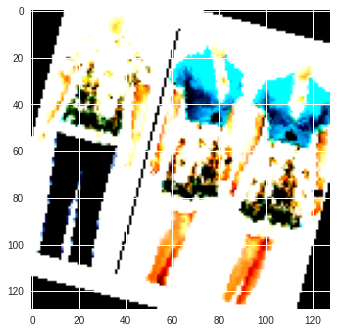

In [108]:
int_label = dict(zip(ints, labels))


img, label = train_set[random.randint(0, len(X_train))]
plt.imshow(img.permute(1,2,0));
print(int_label[label])

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=20, bias=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [109]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

In [ ]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []

for e in range(epoch):
    model.to(device)
    model.train()
    
    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        
        train_loss += loss
        train_acc += accuracy(output, label)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
    else:
        with torch.no_grad():
            model.eval()
            
            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss
                
    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))
    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epochs 1/20.. train loss 3.101.. val loss 2.509.. train accuracy 0.085.. val accuracy 0.308.. time 18.474 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 2/20.. train loss 2.043.. val loss 1.466.. train accuracy 0.456.. val accuracy 0.769.. time 19.811 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 3/20.. train loss 0.845.. val loss 0.817.. train accuracy 0.749.. val accuracy 0.769.. time 18.620 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 4/20.. train loss 0.383.. val loss 0.722.. train accuracy 0.867.. val accuracy 0.731.. time 19.153 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 5/20.. train loss 0.347.. val loss 0.938.. train accuracy 0.888.. val accuracy 0.692.. time 18.180 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 6/20.. train loss 0.692.. val loss 2.938.. train accuracy 0.796.. val accuracy 0.462.. time 18.122 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 7/20.. train loss 0.972.. val loss 2.569.. train accuracy 0.740.. val accuracy 0.577.. time 18.101 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 8/20.. train loss 0.799.. val loss 2.033.. train accuracy 0.748.. val accuracy 0.692.. time 18.090 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 9/20.. train loss 0.796.. val loss 3.162.. train accuracy 0.769.. val accuracy 0.615.. time 18.108 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 10/20.. train loss 0.644.. val loss 1.775.. train accuracy 0.791.. val accuracy 0.577.. time 17.963 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 11/20.. train loss 0.511.. val loss 1.463.. train accuracy 0.838.. val accuracy 0.538.. time 18.062 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 12/20.. train loss 0.199.. val loss 1.442.. train accuracy 0.909.. val accuracy 0.654.. time 18.136 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 13/20.. train loss 0.399.. val loss 1.239.. train accuracy 0.903.. val accuracy 0.615.. time 18.146 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 14/20.. train loss 0.156.. val loss 1.101.. train accuracy 0.951.. val accuracy 0.577.. time 18.258 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 15/20.. train loss 0.188.. val loss 0.970.. train accuracy 0.951.. val accuracy 0.577.. time 18.119 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 16/20.. train loss 0.110.. val loss 0.968.. train accuracy 0.986.. val accuracy 0.692.. time 18.249 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 17/20.. train loss 0.163.. val loss 0.954.. train accuracy 0.944.. val accuracy 0.654.. time 18.065 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 18/20.. train loss 0.067.. val loss 0.965.. train accuracy 0.972.. val accuracy 0.654.. time 18.101 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 19/20.. train loss 0.073.. val loss 0.891.. train accuracy 0.979.. val accuracy 0.731.. time 18.098 s


  0%|          | 0/6 [00:00<?, ?it/s]

epochs 20/20.. train loss 0.056.. val loss 0.878.. train accuracy 0.979.. val accuracy 0.692.. time 18.069 s


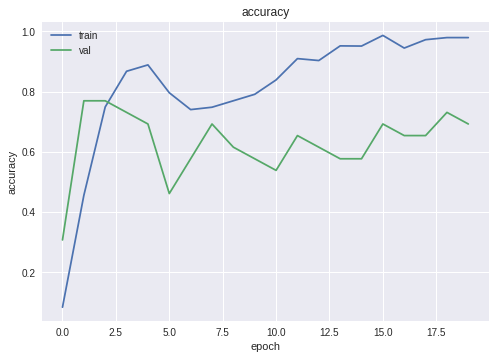

In [ ]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

In [111]:
test_set = Batik(X_test, y_test, PATH, transform=val_transform)

def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
  img, label = test_set[i]
  prediction = predict(model, img, label)
  test_predict.append(prediction)
  true_label.append(label)

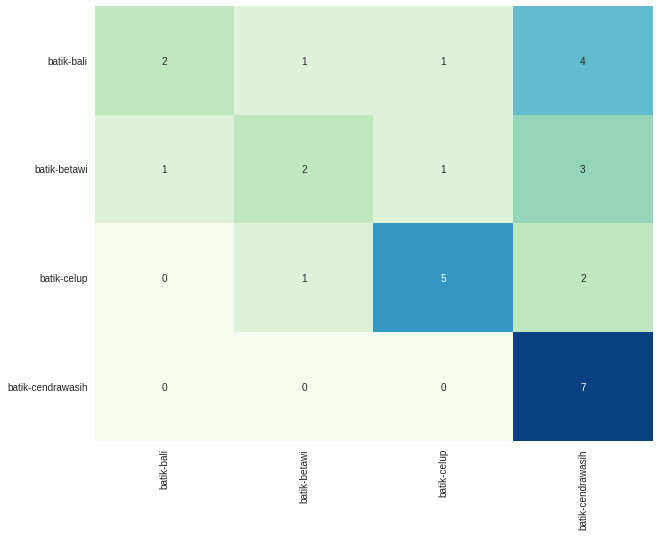

In [112]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu', cbar=False)
plt.xticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=0)
plt.show()

In [ ]:
print(classification_report(true_label, test_predict))

              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.50      0.29      0.36         7
           2       0.71      0.62      0.67         8
           3       0.44      1.00      0.61         7

    accuracy                           0.53        30
   macro avg       0.58      0.54      0.50        30
weighted avg       0.59      0.53      0.50        30



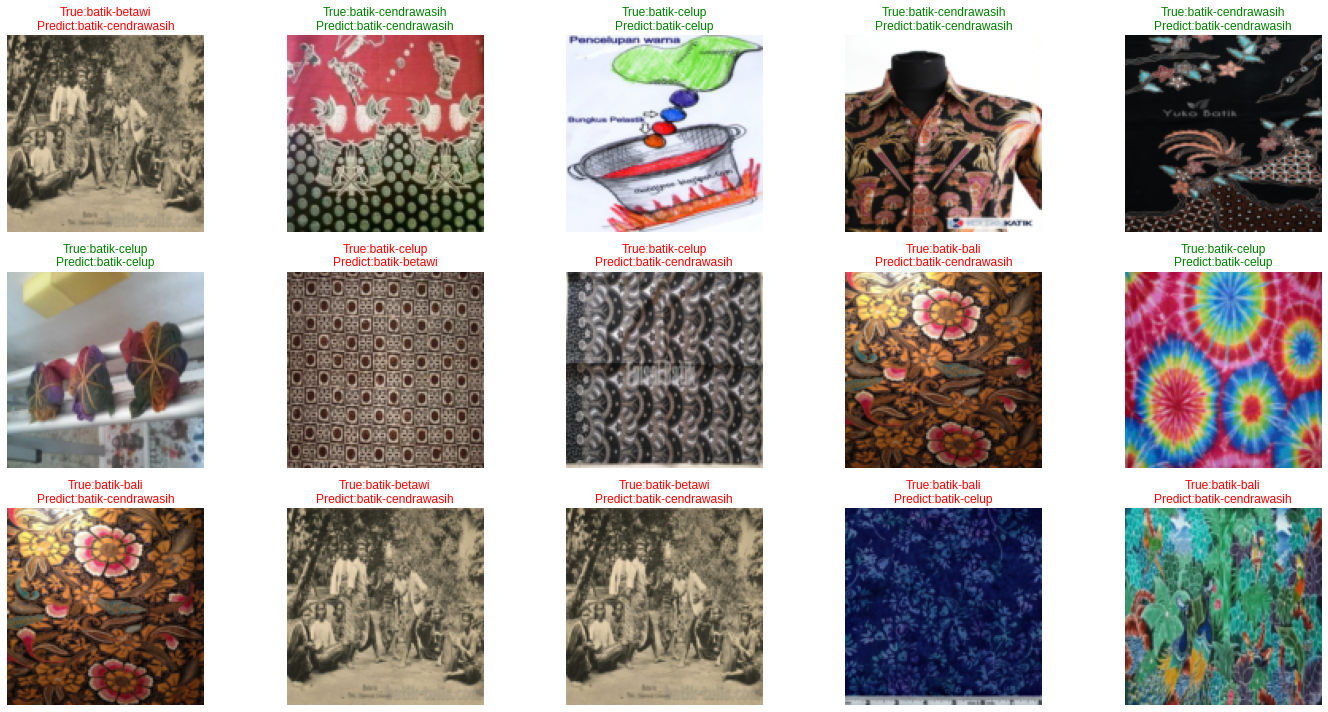

In [ ]:
random_selection = np.random.randint(0, len(test_predict), 15)

fig = plt.figure(figsize=(20, 10))

test_set = Batik (X_test, y_test, PATH, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image)
    ax.set_title('True:{}\nPredict:{}'.format(int_label[label], int_label[test_predict[idx]]),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout()
plt.show()